# The CBacktester Class

## Import libraries and packages

In [30]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

import seaborn as sns
plt.style.use('seaborn')

## Build CBacktester

In [90]:
class CBacktester():
    '''This is a docstring'''
    def __init__(self, filepath, symbol, start, end, tc):
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.dev = 2
        self.sma = 20
        self.data = None
        self.results = None
        self.get_data()
        self.td_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "CBacktester: symbol = {}, start = {}, end = {}, ptc = {}".\
        format(self.symbol, self.start, self.end, self.tc)
        
    def get_data(self):
        raw = pd.read_csv(self.filepath, parse_dates=['time'], index_col='time')
        raw = raw[self.symbol].to_frame().fillna(method = 'ffill')
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol:'price'}, inplace=True)
        raw['returns'] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
    
    def upsample(self): #review this method
        data = self.data.copy()
        resamp = self.results.copy()
        
        data['position'] = resamp.position.shift(1) #review: not sure why this is being called
        data = data.loc[data.index[0]:].copy()
        data.position = data.position.shift(-1).ffill() #review: not sure why this is being called
        data.dropna(inplace=True)
        self.results = data
    
    def prepare_data(self, freq, sma, dev):
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        self.sma = sma
        self.dev = dev
        #resample() requires an agg method, such as last(), first(), mean(), etc
        resamp = data.resample(freq).last().dropna().iloc[:-1] #the last bar is incomplete, so drop it
        resamp['returns'] = np.log(resamp/resamp.shift(1)) #take returns on the resampled data
        #resamp['roll_return'] = resamp['returns'].rolling(window).mean()
        #resamp['position'] = -np.sign(resamp['roll_return'])
        ##############
        ###############
        ###############
        
        resamp["sma"] = resamp.price.rolling(self.sma).mean()
        resamp.dropna(inplace=True)
        resamp["Lower"] = resamp["sma"] - resamp.price.rolling(self.sma).std() * self.dev
        resamp["Upper"] = resamp["sma"] + resamp.price.rolling(self.sma).std() * self.dev
        #return resamp
        resamp["distance"] = resamp.price - resamp.sma
        resamp["position"] = np.where(resamp.price < resamp.Lower, 1, np.nan)
        resamp["position"] = np.where(resamp.price > resamp.Upper, -1, resamp["position"])
        resamp["position"] = np.where(resamp.distance * resamp.distance.shift(1) < 0, 0, resamp["position"])
        resamp["position"] = resamp.position.ffill().fillna(0)
        ##############
        ###############
        ###############
        resamp.dropna(inplace=True)
        self.results = resamp
        return resamp

    def run_backtest(self):
        data = self.results.copy()
        data['strategy'] = data['position'].shift(1) * data['returns']
        
        data['trades'] = data.position.diff().fillna(0).abs() #finds the difference between the rows in 'position'
        data['ctrades'] = data.trades.cumsum()
        data.strategy = data.strategy - data['trades'] * self.tc #subtract trading costs from strategy
        self.results = data       
    
    def test_strategy(self, freq = 60, sma = 20, dev = 2):
        self.freq = "{}".format(freq)
        self.sma = sma
        self.dev = dev
        #print(self.sma)
        #return
        self.prepare_data(freq,int(sma),dev)
        self.upsample()
        self.run_backtest()
        
        data = self.results.copy()
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
          
    def plot_results(self, leverage = False):
        if self.results is None:
            print('run test_strategy() first')
            return
        elif leverage:
            self.results[['creturns', 'cstrategy', 'cstrategy_levered']].plot(logy=False, figsize=(15,8),\
            title = '{} | Frequency: {} | SMA: {} | DEV: {} | TC: {:.6f} | Leverage: {:.2f}'.\
            format(self.symbol, self.freq, self.sma, self.dev, round(self.tc,6), self.leverage))
        else:    
            self.results[['creturns', 'cstrategy']].plot(logy=False, figsize=(15,8),\
            title = '{} | Frequency: {} | SMA: {} | DEV: {} | TC: {}'.\
            format(self.symbol, self.freq, self.sma, self.dev, round(self.tc,6)))
            
    def optimize_strategy(self, freq_range, sma_range, dev_range,  metric = "Multiple"):
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        
        performance = []
        i = 0
        freqs = range(*freq_range)
        smas = range(*sma_range)
        #return np.linspace(*dev_range) #############################################################################
        devs = np.linspace(*dev_range)
        combinations = list(product(freqs, smas, devs))
        
        for comb in combinations:
            clear_output(wait=True)
            display('Optimization in progress... Iteration {} of {}. Testing: freq = {}, sma = {}, dev = {}'.\
                    format(i, len(combinations), comb[0], comb[1], comb[2]))
            self.test_strategy(comb[0], comb[1], comb[2])
            self.upsample() #review: not sure why this is being called
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
            i += 1
            
        self.results_overview = pd.DataFrame(data = np.array(combinations), columns = ['Freq', 'Sma', 'Dev'])
        self.results_overview['Performance'] = performance
         
        self.find_best_strategy()
            
    
    def find_best_strategy(self):
        self.best = self.results_overview.nlargest(1, "Performance")
        freq = self.best.Freq.iloc[0]
        sma = self.best.Sma.iloc[0]
        dev = self.best.Dev.iloc[0]
        perf = self.best.Performance.iloc[0]
        clear_output(wait=True) #clear output again after last iteration
        print(100 * "=")
        print('BEST COMBINATION: FREQUENCY = {}-MINUTE CHART | SMA = {} | DEV = {} | {} = {}'.format(freq, sma, dev, 'Multiple', round(perf,6)))
        print(100 * "-")
        print("\n")
        
        self.test_strategy(freq, sma, dev)
        
    def visualize_many(self):
        if self.results is None:
            print('Run test_strategy() first.')
        else:
            matrix = self.results_overview.pivot_table(index='Freq', columns='Sma', values='Performance', aggfunc='max')
            plt.figure(figsize=(15,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = 'RdYlGn', robust=True, cbar_kws = {"label":'{}'.format(self.metric)})
            plt.show()
            
            
    def add_sessions(self, visualize = False):
        data = self.results.copy()
        
        data['session'] = np.sign(data.trades).cumsum().shift(1).fillna(0)
        
        #cumulative log returns per trading session
        data['logr_session'] = data.groupby('session').strategy.cumsum() 
        
        #cumulative simple returns per trading session
        data['session_compound'] = data.groupby('session').strategy.cumsum().apply(np.exp) - 1
        
        self.results = data
        
        if visualize:
            data['session_compound'].plot(figsize=(12,8))
            plt.show()
        
        
    def add_stop_loss(self, sl_thresh, report = True):
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print('Run test_strategy() first.')
        
        self.add_sessions()
        self.results = self.results.groupby('session').apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions(report)
        
        if report:
            self.print_performance()
        
    
    def add_take_profit(self, tp_thresh, report = True):
        self.tp_thresh = tp_thresh
        
        if self.results is None:
            print('Run test_strategy() first.')
        
        self.add_sessions()
        self.results = self.results.groupby('session').apply(self.define_tp_pos)
        self.run_backtest()
        data = self.results.copy()
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions(report)
        
        if report:
            self.print_performance()
    
    def define_sl_pos(self, group):
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, 'position'] = 0
            return group
        else:
            return group
    
    def define_tp_pos(self, group):
        if (group.session_compound >= self.tp_thresh).any():
            start = group[group.session_compound >= self.tp_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, 'position'] = 0
            return group
        else:
            return group
    
    def add_leverage(self, leverage, sl = -0.5, report = True):
        self.leverage = leverage
        sl_thresh = sl / leverage #remember, leverage multiplies losses, so you must cut the sl!
        
        self.add_stop_loss(sl_thresh, report = False)
        
        data = self.results.copy()
        data['simple_ret'] = np.exp(data.strategy) - 1 
        data['eff_lev'] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
        data.eff_lev.fillna(leverage, inplace=True)
        data.loc[data.trades != 0, 'eff_lev'] = leverage
        levered_returns = data.eff_lev.shift() * data.simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data['strategy_levered'] = levered_returns
        data['cstrategy_levered'] = data.strategy_levered.add(1).cumprod()
        self.results = data
        
        if report:
            self.print_performance(leverage = True)
        
    
    def print_performance(self, leverage = False):
        data = self.results.copy()
        
        if leverage:
            to_analyze = np.log(data.strategy_levered.add(1))
        else:
            to_analyze = data.strategy
        
        bh_multiple =               round(self.calculate_multiple(data.returns),6)
        strategy_multiple =         round(self.calculate_multiple(to_analyze),6)
        strategy_cagr =             round(self.calculate_cagr(to_analyze),6)
        outperf =                   round(strategy_multiple - bh_multiple, 6)
        strategy_ann_mean =         round(self.calculate_annulized_mean(to_analyze),6)
        strategy_ann_std =          round(self.calculate_annulized_std(to_analyze),6)
        strategy_sharpe =           round(self.calculate_sharpe(to_analyze),6)
        strategy_sortino =          round(self.calculate_sortino(to_analyze),6)
        strategy_max_dd =           round(self.calculate_max_drawdown(to_analyze),6)
        strategy_calmar =           round(self.calculate_calmar(to_analyze),6)
        strategy_max_dd_dur =       round(self.calculate_max_dd_duration(to_analyze),6)
        strategy_kelly =            round(self.calculate_kelly_criterion(to_analyze),6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | FREQ = {} | SMA = {} | DEV = {}".format(self.symbol, self.freq, self.sma, self.dev))
        print(100 * "-")
        print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {:,.6f}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {:,.6f}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {:,.6f}".format(outperf))
        print("\n")
        print("CAGR:                        {:,.6f}".format(strategy_cagr))
        print("Annualized Mean:             {:,.6f}".format(strategy_ann_mean))
        print("Annualized Std:              {:,.6f}".format(strategy_ann_std))
        print("Sharpe Ratio:                {:,.6f}".format(strategy_sharpe))
        print("Sortino Ratio:               {:,.6f}".format(strategy_sortino))
        print("Maximum Drawdown:            {:,.6f}".format(strategy_max_dd))
        print("Calmar Ratio:                {:,.6f}".format(strategy_calmar))
        print("Max Drawdown Duration:       {} Days".format(strategy_max_dd_dur))
        print("Kelly Criterion:             {:,.6f}".format(strategy_kelly))
        
        print(100 * "=")
        
    
    def calculate_multiple(self, series):
        #return series.iloc[-1]/series.iloc[0] #this returns multiple if the series is PRICE data
        return np.exp(series.sum()) #returns muliple if the series is log returns (does work with nan in 0 pos)
        #return series.cumsum().apply(np.exp).iloc[-1]
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annulized_mean(self, series):
        return series.mean() * self.td_year
    
    def calculate_annulized_std(self, series):
        return series.std() * np.sqrt(self.td_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.td_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.td_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()

## CBacktester in Use

In [98]:
spread = 1.4
pips = 0.0001

tester = CBacktester("one_minute.csv", "EURAUD", "2018-01-01", "2019-12-31", spread*pips/2) #mult by 2 for a 'round trip', multiply by pips

tester.prepare_data(freq = 60, sma = 20, dev = 2)

##test strategy as a speicifc window and freq
tester.test_strategy(freq = 60, sma = 20, dev = 2)


##optimize for a given metric
#tester.optimize_strategy((1,400,24),(25,200,12),(1,3,18), metric = "Multiple") #full

start = []

tester.optimize_strategy((1,400,6),(1,400,6),(1,5,12), metric = "Multiple") #quick
#tester.optimize_strategy((205,400,50),(10,150,25),(1,2,6), metric = "Multiple") #quick

##show all tested combinations (this must be commented out if optimize_strategy is commented out)
#tester.visualize_many()

#add SL to tester object
#tester.add_stop_loss(-0.005, True)

#add TP to tester object
#tester.add_take_profit(0.005, True)

#add half kelly leverage
#half_kelly = (tester.calculate_kelly_criterion(tester.results.strategy))/2
#tester.add_leverage(leverage = half_kelly, sl = -0.35)

#plot results and print performance
#tester.plot_results(leverage = True)

BEST COMBINATION: FREQUENCY = 25.0-MINUTE CHART | SMA = 121.0 | DEV = 2.8181818181818183 | Multiple = 1.192359
----------------------------------------------------------------------------------------------------




In [99]:
tester.results_overview.sort_values(by='Performance').pivot_table(index='Dev', columns='Sma', values='Performance', aggfunc='max')

Sma,1.0,7.0,13.0,19.0,25.0,31.0,37.0,43.0,49.0,55.0,...,343.0,349.0,355.0,361.0,367.0,373.0,379.0,385.0,391.0,397.0
Dev,,,,,,,,,,,,,,,,,,,,,
1.000000,1.0,1.130890,1.102830,1.111985,1.091497,1.098760,1.095292,1.105030,1.102633,1.098149,...,1.119354,1.129924,1.128398,1.138052,1.122908,1.132264,1.139548,1.137227,1.135026,1.144179
1.363636,1.0,1.168930,1.136998,1.137298,1.099525,1.099441,1.090494,1.071243,1.092037,1.079658,...,1.129735,1.115730,1.110763,1.115022,1.107340,1.116538,1.113589,1.126628,1.128429,1.125456
1.727273,1.0,1.118321,1.136769,1.116445,1.114107,1.121765,1.106373,1.105373,1.108020,1.104361,...,1.118044,1.121534,1.122161,1.125619,1.105643,1.108083,1.113321,1.116663,1.118919,1.120808
2.090909,1.0,1.063890,1.131962,1.132322,1.156900,1.122301,1.117649,1.133200,1.117144,1.101215,...,1.119985,1.110291,1.114110,1.114879,1.126154,1.103316,1.107520,1.119347,1.108369,1.119845
2.454545,1.0,1.000000,1.110073,1.112541,1.128758,1.140909,1.149358,1.187525,1.158775,1.139162,...,1.089213,1.078955,1.084709,1.075238,1.081380,1.093466,1.084289,1.084729,1.093248,1.093634
2.818182,1.0,1.000000,1.057151,1.098984,1.100446,1.109880,1.138401,1.173867,1.144422,1.146091,...,1.168484,1.149445,1.149025,1.139121,1.146989,1.148621,1.130840,1.124035,1.105571,1.110830
3.181818,1.0,1.000000,1.015175,1.049733,1.089081,1.101193,1.125905,1.090526,1.109533,1.133491,...,1.141803,1.138891,1.137518,1.123243,1.116090,1.116999,1.121818,1.112872,1.118918,1.122870
3.545455,1.0,1.000000,1.000150,1.023711,1.054695,1.058016,1.061180,1.064622,1.071579,1.088480,...,1.147950,1.134818,1.162302,1.153614,1.150354,1.131292,1.127173,1.135694,1.130421,1.117785
3.909091,1.0,1.000000,1.000150,1.016364,1.039717,1.048192,1.069259,1.043484,1.053446,1.053021,...,1.100558,1.099433,1.104866,1.106922,1.113333,1.105278,1.090665,1.098607,1.105267,1.105669


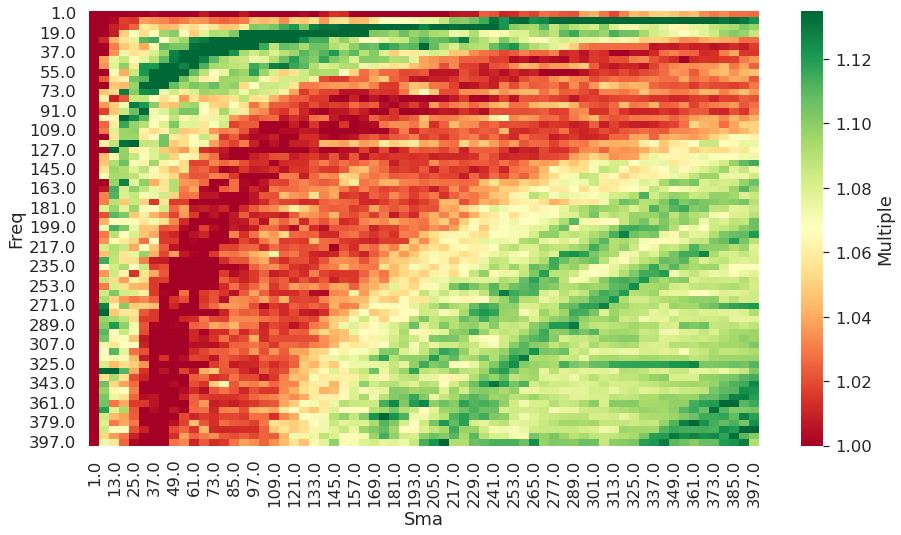

In [100]:
##show all tested combinations (this must be commented out if optimize_strategy is commented out)
tester.visualize_many()

#add SL to tester object
#tester.add_stop_loss(-0.005, True)

#add TP to tester object
#tester.add_take_profit(0.005, True)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURAUD | FREQ = 25.0 | SMA = 121 | DEV = 2.8181818181818183
----------------------------------------------------------------------------------------------------


PERFORMANCE MEASURES:


Multiple (Strategy):         15.827819
Multiple (Buy-and-Hold):     1.044632
--------------------------------------
Out-/Underperformance:       14.783187


CAGR:                        3.051468
Annualized Mean:             1.396896
Annualized Std:              0.985815
Sharpe Ratio:                1.416996
Sortino Ratio:               2.010202
Maximum Drawdown:            0.694680
Calmar Ratio:                4.392622
Max Drawdown Duration:       168 Days
Kelly Criterion:             1.937672


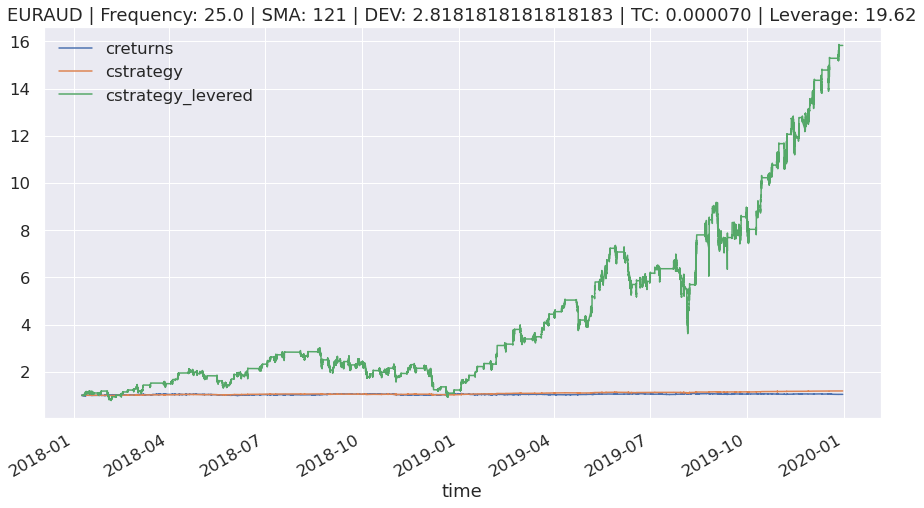

In [101]:
#add half kelly leverage
half_kelly = (tester.calculate_kelly_criterion(tester.results.strategy))/2
tester.add_leverage(leverage = half_kelly, sl = -0.4)

#plot results and print performance
tester.plot_results(leverage = True)

In [103]:
tester.results

,price,returns,position,strategy,trades,ctrades,creturns,cstrategy,session,logr_session,session_compound,simple_ret,eff_lev,strategy_levered,cstrategy_levered
time,,,,,,,,,,,,,,,
2018-01-08 01:34:00,1.53140,0.000144,0.0,NaN,0.0,0.0,1.000144,NaN,0.0,NaN,NaN,NaN,19.618267,NaN,NaN
2018-01-08 01:35:00,1.53136,-0.000026,0.0,-0.0,0.0,0.0,1.000118,1.000000,0.0,0.0,0.0,0.0,19.618267,0.0,1.000000
2018-01-08 01:36:00,1.53162,0.000170,0.0,0.0,0.0,0.0,1.000287,1.000000,0.0,0.0,0.0,0.0,19.618267,0.0,1.000000
2018-01-08 01:37:00,1.53168,0.000039,0.0,0.0,0.0,0.0,1.000327,1.000000,0.0,0.0,0.0,0.0,19.618267,0.0,1.000000
2018-01-08 01:38:00,1.53174,0.000039,0.0,0.0,0.0,0.0,1.000366,1.000000,0.0,0.0,0.0,0.0,19.618267,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.59978,-0.000163,0.0,-0.0,0.0,308.0,1.044802,1.188746,308.0,0.0,0.0,0.0,19.618267,0.0,15.827819
2019-12-30 23:57:00,1.60000,0.000138,0.0,0.0,0.0,308.0,1.044946,1.188746,308.0,0.0,0.0,0.0,19.618267,0.0,15.827819
2019-12-30 23:58:00,1.59994,-0.000038,0.0,-0.0,0.0,308.0,1.044907,1.188746,308.0,0.0,0.0,0.0,19.618267,0.0,15.827819


## Utility: Find number of combinations

In [181]:
#(1,400,24),(1,200,24),(1,3,9)
freqs = range(1,400,24)
smas = range(1,200,24)
#return np.linspace(*dev_range) #############################################################################
devs = np.linspace(1,3,9)
combinations = list(product(freqs, smas, devs))
len(combinations)

1377

In [20]:
tester.results_overview[tester.results_overview.Freq == 49+24].sort_values(by="Performance", ascending=False)

,Freq,Sma,Dev,Performance


In [19]:
para = Out[201]
para

KeyError: 201